# Main

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/final_term_final/food_datasets

Mounted at /content/drive
/content/drive/MyDrive/final_term_final/food_datasets


In [2]:
import torch
import torchvision

print(torch.__version__, torchvision.__version__)

2.1.0+cu121 0.16.0+cu121


Restart after running the following two snippets

In [3]:
#!pip3 uninstall torch torchvision --y

In [4]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

## Setup

In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2

from torch.utils.data import Dataset, DataLoader

import os
import argparse

import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('/content/drive/MyDrive/final_term_final/')
from utils import *
from model import *

import warnings
warnings.simplefilter("ignore", UserWarning)

### Set Device

In [6]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

### Get Dataset

In [7]:
train_dataset = Food_Dataset('train')
test_set_pre = Food_Dataset('test')

label: frankie


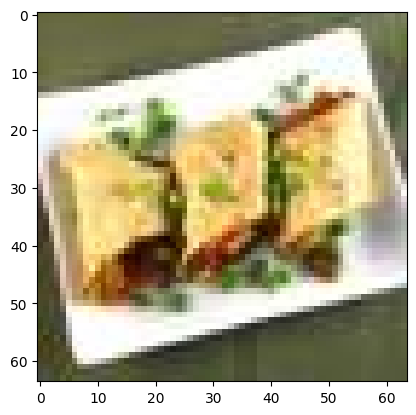

In [8]:
image, label = train_dataset[0]

class_info = pd.read_csv('class_info.csv')
plt.imshow(image.permute(1,2,0))
print(f"label: {class_info[class_info['class_index'] == label.item()]['class_name'].item()}")

### Split Dataset

In [9]:
from torch.utils.data import random_split

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [10]:
train_set = Food_Subset_toset(train_subset)
val_set = Food_Subset_toset(val_subset)
test_set = Food_Subset_toset(test_set_pre)

## Data Preprocessing

### Get Mean and Standard Deviation

In [11]:
train_mean, train_std = get_mean_std(train_set, batch_size=32, num_workers=2)
val_mean, val_std = get_mean_std(val_set, batch_size=32, num_workers=2)
test_mean, test_std = get_mean_std(test_set, batch_size=32, num_workers=2)

### Data Augmentation

In [12]:
to_float_tensor = ToFloatTensor()
to_uint8_tensor = ToUInt8Tensor()

train_transformation_def = v2.Compose([
                        v2.Resize(64, antialias=False),
                        v2.Normalize(train_mean, train_std),
])

train_transformation_simple = v2.Compose([
                        v2.Resize(64, antialias=False),
                        v2.RandomApply(transforms=[v2.RandomHorizontalFlip(),
                                                  v2.RandomVerticalFlip(),
                                                  v2.RandomRotation(45),
                                                  AddGaussianNoise(0., .05),
                                                  v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))], p=1),
                        v2.Normalize(train_mean, train_std),
])

train_transformation_geo = v2.Compose([
                        v2.Resize(64, antialias=False),
                        v2.RandomPerspective(),
                        v2.RandomResizedCrop(64, antialias=True),
                        v2.Normalize(train_mean, train_std),
])

train_transformation_auto = v2.Compose([
                        v2.Resize(64, antialias=True),
                        to_uint8_tensor,
                        v2.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                        to_float_tensor,
                        v2.Normalize(train_mean, train_std),
])

train_transformation_triv = v2.Compose([
                        v2.Resize(64, antialias=True),
                        to_uint8_tensor,
                        v2.TrivialAugmentWide(),
                        to_float_tensor,
                        v2.Normalize(train_mean, train_std),
])

train_transformation_mix = v2.Compose([
                        v2.Resize(64, antialias=True),
                        to_uint8_tensor,
                        v2.AugMix(),
                        to_float_tensor,
                        v2.Normalize(train_mean, train_std),
])

val_transformation = transforms.Compose([
                        v2.Resize(64, antialias=True),
                        v2.Normalize(val_mean, val_std),
])

test_transformation = transforms.Compose([
                        v2.Resize(64, antialias=True),
                        v2.Normalize(test_mean, test_std),
])

In [13]:
import copy

train_set_def = copy.deepcopy(train_set)
train_set_simple = copy.deepcopy(train_set)
train_set_geo = copy.deepcopy(train_set)
train_set_auto = copy.deepcopy(train_set)
train_set_triv = copy.deepcopy(train_set)
train_set_mix = copy.deepcopy(train_set)

In [14]:
train_set_def.transform = train_transformation_def
train_set_simple.transform = train_transformation_simple
train_set_geo.transform = train_transformation_geo
train_set_auto.transform = train_transformation_auto
train_set_triv.transform = train_transformation_triv
train_set_mix.transform = train_transformation_mix

val_set.transform = val_transformation
test_set.transform = test_transformation

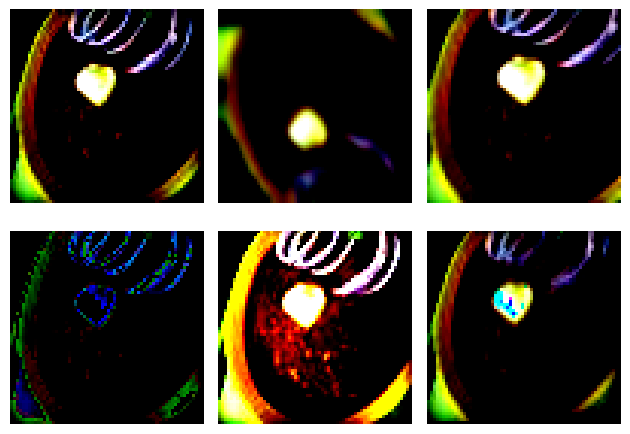

In [15]:
plt.subplot(2, 3, 1)
plt.imshow(train_set_def[0][0].permute(1, 2, 0))
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(train_set_simple[0][0].permute(1, 2, 0))
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(train_set_geo[0][0].permute(1, 2, 0))
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(train_set_auto[0][0].permute(1, 2, 0))
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(train_set_triv[0][0].permute(1, 2, 0))
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(train_set_mix[0][0].permute(1, 2, 0))
plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
from torch.utils.data import ConcatDataset

com_train_set_1 = ConcatDataset([train_set_def, train_set_simple, train_set_geo])
com_train_set_2 = ConcatDataset([train_set_def, train_set_simple, train_set_geo, train_set_auto, train_set_triv, train_set_mix])
val_set.transform = val_transformation
test_set.transform = test_transformation

In [17]:
print(len(com_train_set_1), len(com_train_set_2))

16956 33912


### Create DataLoader

In [18]:
train_dl = DataLoader(train_set, batch_size=len(train_set), num_workers=2)
train_dl_1 = DataLoader(com_train_set_1, batch_size=32, shuffle=True, num_workers=2)
train_dl_2 = DataLoader(com_train_set_2, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_set, batch_size=len(val_set), num_workers=2)
test_dl = DataLoader(test_set, batch_size=len(test_set), num_workers=2)

## EDA \\\ can't perform on colab. takes too long. executed in local machine.

### Class Count

In [19]:
'''
with torch.no_grad():
    class_counts = {}
    for _, labels in train_dl:
        tensor_array = np.array(labels.flatten())

        unique_values, value_counts = np.unique(tensor_array, return_counts=True)
        for value, count in zip(unique_values, value_counts):
            if value not in class_counts:
                class_counts[value] = count
            else:
                class_counts[value] += count

    sorted_counts = {k: v for k, v in sorted(class_counts.items(), key=lambda item: item[0])}

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_counts.keys(), sorted_counts.values(), color='blue')

    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Bar Plot of Class Counts')
    plt.xticks(list(sorted_counts.keys()))
    plt.grid(axis='y')
    plt.show()
'''

'\nwith torch.no_grad():\n    for _, labels in train_dl:\n        tensor_array = np.array(labels.flatten())\n\n        unique_values, value_counts = np.unique(tensor_array, return_counts=True)\n\n        print("Train Class Count")\n        for value, count in zip(unique_values, value_counts):\n            print(f"Class: {value}, Count: {count}")\n'

### Examine Images

In [20]:
'''
class_samples = {}

for images, labels in train_dl:
    for image, label in zip(images, labels):
        label = label.item()
        if label not in class_samples:
            class_samples[label] = image
            if len(class_samples) == 27:
                break
    if len(class_samples) == 27:
        break

sorted_class_ids = sorted(class_samples.keys())

plt.subplots(9, 3, figsize=(10, 20))

for class_id in sorted_class_ids:
    plt.subplot(9, 3, class_id + 1)
    plt.imshow(class_samples[class_id].permute(1, 2, 0))
    plt.axis('off')

plt.tight_layout()
plt.show()
'''

"\nclass_samples = {}\n\nfor images, labels in train_dl:\n    for image, label in zip(images, labels):\n        label = label.item()\n        if label not in class_samples:\n            class_samples[label] = image\n            if len(class_samples) == 27:\n                break\n    if len(class_samples) == 27:\n        break\n\nsorted_class_ids = sorted(class_samples.keys())\n\nplt.subplots(9, 3, figsize=(10, 20))\n\nfor class_id in sorted_class_ids:\n    plt.subplot(9, 3, class_id + 1)\n    plt.imshow(class_samples[class_id].permute(1, 2, 0))\n    plt.axis('off')\n\nplt.tight_layout()\nplt.show()\n"

## Training

### Setup for First Training

In [21]:
cutmix = v2.CutMix(num_classes=27)

class_weights = torch.ones(27)
low_accuracy_classes = [4, 5, 11, 15, 16, 21, 23]
weight_value = 2
class_weights[low_accuracy_classes] = weight_value

In [22]:
net = Net().to(device)
lr = 1e-3
loss_function = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.SGD(net.parameters(), momentum=0.9, lr=lr, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=80, T_mult=2)
epochs = 80

### Start the First Training

#### Train With Augmented Images

In [23]:
from tqdm import tqdm

train_epoch_losses = []
train_epoch_accs = []

val_epoch_losses = []
val_epoch_accs = []

lr_history = []

for epoch in range(epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    train_batch_loss = []
    train_batch_acc = []

    val_batch_loss = []
    val_batch_acc = []

    for i, (images, labels) in tqdm(enumerate(train_dl_2), desc=f"Train epoch {epoch}"):
        net.train()
        images = images.to(device)
        labels = labels.flatten().to(device)

        preds = net(images)
        loss = loss_function(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_batch_loss.append(loss.item())

        net.eval()

        with torch.no_grad():
            y_pred = (net.predict(images)).type(torch.FloatTensor).to(device)
            correct = (y_pred == labels).type(torch.FloatTensor)
            train_batch_acc.append(correct.mean())
    train_epoch_loss = torch.tensor(train_batch_loss).mean()
    train_epoch_acc = torch.tensor(train_batch_acc).mean()
    train_epoch_losses.append(train_epoch_loss)
    train_epoch_accs.append(train_epoch_acc)

    net.eval()

    with torch.no_grad():
        for images, labels in val_dl:
            images = images.to(device)
            labels = labels.flatten().to(device)

            preds = net(images)

            loss = loss_function(preds, labels)
            val_batch_loss.append(loss.item())
            y_pred = (net.predict(images)).type(torch.FloatTensor).to(device)
            correct = (y_pred == labels).type(torch.FloatTensor)
            val_batch_acc.append(correct.mean())

    val_epoch_loss = torch.tensor(val_batch_loss).mean()
    val_epoch_acc = torch.tensor(val_batch_acc).mean()
    val_epoch_losses.append(val_epoch_loss)
    val_epoch_accs.append(val_epoch_acc)

    learningRate = optimizer.param_groups[0]["lr"]

    print(f"Train Loss:      {train_epoch_loss:.4f} | Train Accuracy:      {train_epoch_acc * 100:.4f}%")
    print(f"Validation Loss: {val_epoch_loss:.4f} | Validation Accuracy: {val_epoch_acc * 100:.4f}%, lr = {learningRate:.8f}")

    lr_history.append(learningRate)
    scheduler.step()

Train epoch 0: 1060it [01:37, 10.86it/s]


Train Loss:      3.0776 | Train Accuracy:      23.3854%
Validation Loss: 2.2495 | Validation Accuracy: 36.7250%, lr = 0.00100000


Train epoch 1: 1060it [01:33, 11.31it/s]


Train Loss:      2.3581 | Train Accuracy:      36.4623%
Validation Loss: 2.2015 | Validation Accuracy: 40.6995%, lr = 0.00099961


Train epoch 2: 1060it [01:32, 11.40it/s]


Train Loss:      1.9923 | Train Accuracy:      46.8151%
Validation Loss: 1.8152 | Validation Accuracy: 44.1971%, lr = 0.00099846


Train epoch 3: 1060it [01:36, 11.03it/s]


Train Loss:      1.7260 | Train Accuracy:      54.7258%
Validation Loss: 1.7339 | Validation Accuracy: 51.3513%, lr = 0.00099653


Train epoch 4: 1060it [01:32, 11.51it/s]


Train Loss:      1.4953 | Train Accuracy:      62.0106%
Validation Loss: 1.7868 | Validation Accuracy: 53.5771%, lr = 0.00099384


Train epoch 5: 1060it [01:32, 11.52it/s]


Train Loss:      1.2999 | Train Accuracy:      67.6435%
Validation Loss: 1.7057 | Validation Accuracy: 58.5056%, lr = 0.00099039


Train epoch 6: 1060it [01:31, 11.57it/s]


Train Loss:      1.1578 | Train Accuracy:      71.7905%
Validation Loss: 1.3921 | Validation Accuracy: 57.7107%, lr = 0.00098618


Train epoch 7: 1060it [01:32, 11.42it/s]


Train Loss:      1.0472 | Train Accuracy:      74.8546%
Validation Loss: 1.4085 | Validation Accuracy: 61.0493%, lr = 0.00098123


Train epoch 8: 1060it [01:32, 11.52it/s]


Train Loss:      0.9707 | Train Accuracy:      77.4283%
Validation Loss: 1.5311 | Validation Accuracy: 57.3927%, lr = 0.00097553


Train epoch 9: 1060it [01:32, 11.45it/s]


Train Loss:      0.9333 | Train Accuracy:      78.3648%
Validation Loss: 1.2699 | Validation Accuracy: 62.6391%, lr = 0.00096910


Train epoch 10: 1060it [01:35, 11.14it/s]


Train Loss:      0.8689 | Train Accuracy:      80.1042%
Validation Loss: 1.1941 | Validation Accuracy: 66.1367%, lr = 0.00096194


Train epoch 11: 1060it [01:33, 11.37it/s]


Train Loss:      0.8330 | Train Accuracy:      81.2343%
Validation Loss: 1.3611 | Validation Accuracy: 64.0700%, lr = 0.00095407


Train epoch 12: 1060it [01:32, 11.49it/s]


Train Loss:      0.7946 | Train Accuracy:      82.4725%
Validation Loss: 1.2342 | Validation Accuracy: 65.8188%, lr = 0.00094550


Train epoch 13: 1060it [01:31, 11.59it/s]


Train Loss:      0.7576 | Train Accuracy:      83.5977%
Validation Loss: 1.2577 | Validation Accuracy: 66.4547%, lr = 0.00093625


Train epoch 14: 1060it [01:31, 11.58it/s]


Train Loss:      0.7402 | Train Accuracy:      83.9868%
Validation Loss: 1.0904 | Validation Accuracy: 71.3831%, lr = 0.00092632


Train epoch 15: 1060it [01:31, 11.56it/s]


Train Loss:      0.7199 | Train Accuracy:      84.8143%
Validation Loss: 1.1740 | Validation Accuracy: 66.1367%, lr = 0.00091573


Train epoch 16: 1060it [01:34, 11.18it/s]


Train Loss:      0.6858 | Train Accuracy:      85.7066%
Validation Loss: 1.1344 | Validation Accuracy: 65.3418%, lr = 0.00090451


Train epoch 17: 1060it [01:37, 10.87it/s]


Train Loss:      0.6724 | Train Accuracy:      86.2844%
Validation Loss: 1.0247 | Validation Accuracy: 72.0191%, lr = 0.00089266


Train epoch 18: 1060it [01:34, 11.19it/s]


Train Loss:      0.6680 | Train Accuracy:      86.4505%
Validation Loss: 1.0373 | Validation Accuracy: 70.7472%, lr = 0.00088020


Train epoch 19: 1060it [01:35, 11.13it/s]


Train Loss:      0.6471 | Train Accuracy:      86.9241%
Validation Loss: 1.1191 | Validation Accuracy: 67.7266%, lr = 0.00086716


Train epoch 20: 1060it [01:34, 11.26it/s]


Train Loss:      0.6220 | Train Accuracy:      87.7015%
Validation Loss: 1.0207 | Validation Accuracy: 73.6089%, lr = 0.00085355


Train epoch 21: 1060it [01:34, 11.20it/s]


Train Loss:      0.6189 | Train Accuracy:      87.7024%
Validation Loss: 1.0009 | Validation Accuracy: 70.2703%, lr = 0.00083940


Train epoch 22: 1060it [01:36, 10.99it/s]


Train Loss:      0.5998 | Train Accuracy:      88.4169%
Validation Loss: 1.0531 | Validation Accuracy: 71.2242%, lr = 0.00082472


Train epoch 23: 1060it [01:36, 11.02it/s]


Train Loss:      0.5947 | Train Accuracy:      88.5800%
Validation Loss: 1.0063 | Validation Accuracy: 69.9523%, lr = 0.00080955


Train epoch 24: 1060it [01:34, 11.25it/s]


Train Loss:      0.5945 | Train Accuracy:      88.7638%
Validation Loss: 1.0550 | Validation Accuracy: 72.1781%, lr = 0.00079389


Train epoch 25: 1060it [01:33, 11.33it/s]


Train Loss:      0.5792 | Train Accuracy:      89.1824%
Validation Loss: 1.0069 | Validation Accuracy: 71.5421%, lr = 0.00077779


Train epoch 26: 1060it [01:31, 11.64it/s]


Train Loss:      0.5738 | Train Accuracy:      89.4693%
Validation Loss: 1.0456 | Validation Accuracy: 71.0652%, lr = 0.00076125


Train epoch 27: 1060it [01:31, 11.62it/s]


Train Loss:      0.5611 | Train Accuracy:      89.7533%
Validation Loss: 0.9827 | Validation Accuracy: 71.7011%, lr = 0.00074431


Train epoch 28: 1060it [01:32, 11.52it/s]


Train Loss:      0.5600 | Train Accuracy:      89.8624%
Validation Loss: 1.0692 | Validation Accuracy: 69.6343%, lr = 0.00072700


Train epoch 29: 1060it [01:34, 11.24it/s]


Train Loss:      0.5581 | Train Accuracy:      89.6875%
Validation Loss: 0.9974 | Validation Accuracy: 72.9730%, lr = 0.00070933


Train epoch 30: 1060it [01:31, 11.54it/s]


Train Loss:      0.5376 | Train Accuracy:      90.3263%
Validation Loss: 1.0049 | Validation Accuracy: 70.5882%, lr = 0.00069134


Train epoch 31: 1060it [01:32, 11.42it/s]


Train Loss:      0.5315 | Train Accuracy:      90.2604%
Validation Loss: 1.1493 | Validation Accuracy: 68.9984%, lr = 0.00067306


Train epoch 32: 1060it [01:31, 11.64it/s]


Train Loss:      0.5230 | Train Accuracy:      90.4776%
Validation Loss: 0.9720 | Validation Accuracy: 73.4499%, lr = 0.00065451


Train epoch 33: 1060it [01:32, 11.48it/s]


Train Loss:      0.5147 | Train Accuracy:      90.7930%
Validation Loss: 1.0091 | Validation Accuracy: 71.2242%, lr = 0.00063572


Train epoch 34: 1060it [01:31, 11.53it/s]


Train Loss:      0.5083 | Train Accuracy:      90.8815%
Validation Loss: 0.9995 | Validation Accuracy: 71.0652%, lr = 0.00061672


Train epoch 35: 1060it [01:34, 11.19it/s]


Train Loss:      0.4978 | Train Accuracy:      91.0859%
Validation Loss: 1.0194 | Validation Accuracy: 71.3831%, lr = 0.00059755


Train epoch 36: 1060it [01:32, 11.46it/s]


Train Loss:      0.4902 | Train Accuracy:      91.1724%
Validation Loss: 1.0870 | Validation Accuracy: 72.4960%, lr = 0.00057822


Train epoch 37: 1060it [01:31, 11.53it/s]


Train Loss:      0.4869 | Train Accuracy:      91.2706%
Validation Loss: 1.0345 | Validation Accuracy: 71.7011%, lr = 0.00055877


Train epoch 38: 1060it [01:32, 11.52it/s]


Train Loss:      0.4802 | Train Accuracy:      91.4416%
Validation Loss: 1.0069 | Validation Accuracy: 71.5421%, lr = 0.00053923


Train epoch 39: 1060it [01:32, 11.51it/s]


Train Loss:      0.4721 | Train Accuracy:      91.6126%
Validation Loss: 1.1142 | Validation Accuracy: 69.4754%, lr = 0.00051963


Train epoch 40: 1060it [01:32, 11.48it/s]


Train Loss:      0.4667 | Train Accuracy:      91.5291%
Validation Loss: 0.9904 | Validation Accuracy: 72.4960%, lr = 0.00050000


Train epoch 41: 1060it [01:33, 11.38it/s]


Train Loss:      0.4490 | Train Accuracy:      92.0293%
Validation Loss: 1.0226 | Validation Accuracy: 72.1781%, lr = 0.00048037


Train epoch 42: 1060it [01:35, 11.15it/s]


Train Loss:      0.4510 | Train Accuracy:      91.8062%
Validation Loss: 0.9539 | Validation Accuracy: 72.4960%, lr = 0.00046077


Train epoch 43: 1060it [01:32, 11.46it/s]


Train Loss:      0.4377 | Train Accuracy:      92.0774%
Validation Loss: 0.9873 | Validation Accuracy: 71.8601%, lr = 0.00044123


Train epoch 44: 1060it [01:31, 11.60it/s]


Train Loss:      0.4347 | Train Accuracy:      92.2445%
Validation Loss: 1.0475 | Validation Accuracy: 72.9730%, lr = 0.00042178


Train epoch 45: 1060it [01:30, 11.66it/s]


Train Loss:      0.4304 | Train Accuracy:      92.2327%
Validation Loss: 1.0705 | Validation Accuracy: 70.4293%, lr = 0.00040245


Train epoch 46: 1060it [01:32, 11.47it/s]


Train Loss:      0.4133 | Train Accuracy:      92.4528%
Validation Loss: 0.9620 | Validation Accuracy: 75.8347%, lr = 0.00038328


Train epoch 47: 1060it [01:32, 11.46it/s]


Train Loss:      0.4023 | Train Accuracy:      92.6415%
Validation Loss: 0.9252 | Validation Accuracy: 76.4706%, lr = 0.00036428


Train epoch 48: 1060it [01:34, 11.20it/s]


Train Loss:      0.3878 | Train Accuracy:      92.9560%
Validation Loss: 0.9553 | Validation Accuracy: 73.2909%, lr = 0.00034549


Train epoch 49: 1060it [01:32, 11.47it/s]


Train Loss:      0.3900 | Train Accuracy:      92.8626%
Validation Loss: 1.0939 | Validation Accuracy: 71.3831%, lr = 0.00032694


Train epoch 50: 1060it [01:31, 11.56it/s]


Train Loss:      0.3802 | Train Accuracy:      93.0503%
Validation Loss: 0.8917 | Validation Accuracy: 75.8347%, lr = 0.00030866


Train epoch 51: 1060it [01:31, 11.53it/s]


Train Loss:      0.3584 | Train Accuracy:      93.3235%
Validation Loss: 0.9458 | Validation Accuracy: 72.9730%, lr = 0.00029067


Train epoch 52: 1060it [01:32, 11.47it/s]


Train Loss:      0.3600 | Train Accuracy:      93.2773%
Validation Loss: 0.9930 | Validation Accuracy: 73.2909%, lr = 0.00027300


Train epoch 53: 1060it [01:31, 11.54it/s]


Train Loss:      0.3498 | Train Accuracy:      93.4159%
Validation Loss: 0.9418 | Validation Accuracy: 75.3577%, lr = 0.00025569


Train epoch 54: 1060it [01:32, 11.52it/s]


Train Loss:      0.3458 | Train Accuracy:      93.4483%
Validation Loss: 0.9814 | Validation Accuracy: 74.4038%, lr = 0.00023875


Train epoch 55: 1060it [01:34, 11.24it/s]


Train Loss:      0.3308 | Train Accuracy:      93.7903%
Validation Loss: 1.0657 | Validation Accuracy: 72.3370%, lr = 0.00022221


Train epoch 56: 1060it [01:32, 11.51it/s]


Train Loss:      0.3277 | Train Accuracy:      93.7785%
Validation Loss: 0.8595 | Validation Accuracy: 77.4245%, lr = 0.00020611


Train epoch 57: 1060it [01:32, 11.42it/s]


Train Loss:      0.3132 | Train Accuracy:      94.0320%
Validation Loss: 0.9762 | Validation Accuracy: 72.3370%, lr = 0.00019045


Train epoch 58: 1060it [01:31, 11.53it/s]


Train Loss:      0.3054 | Train Accuracy:      94.1490%
Validation Loss: 0.9331 | Validation Accuracy: 75.5167%, lr = 0.00017528


Train epoch 59: 1060it [01:32, 11.41it/s]


Train Loss:      0.2976 | Train Accuracy:      94.1509%
Validation Loss: 0.8746 | Validation Accuracy: 74.2448%, lr = 0.00016060


Train epoch 60: 1060it [01:32, 11.42it/s]


Train Loss:      0.2874 | Train Accuracy:      94.3858%
Validation Loss: 0.9170 | Validation Accuracy: 74.7218%, lr = 0.00014645


Train epoch 61: 1060it [01:36, 11.02it/s]


Train Loss:      0.2774 | Train Accuracy:      94.4919%
Validation Loss: 0.9199 | Validation Accuracy: 76.1526%, lr = 0.00013284


Train epoch 62: 1060it [01:31, 11.55it/s]


Train Loss:      0.2698 | Train Accuracy:      94.5342%
Validation Loss: 0.8944 | Validation Accuracy: 76.4706%, lr = 0.00011980


Train epoch 63: 1060it [01:31, 11.54it/s]


Train Loss:      0.2546 | Train Accuracy:      94.7966%
Validation Loss: 0.9163 | Validation Accuracy: 76.1526%, lr = 0.00010734


Train epoch 64: 1060it [01:31, 11.57it/s]


Train Loss:      0.2510 | Train Accuracy:      94.8899%
Validation Loss: 0.8914 | Validation Accuracy: 76.7886%, lr = 0.00009549


Train epoch 65: 1060it [01:32, 11.44it/s]


Train Loss:      0.2404 | Train Accuracy:      94.9263%
Validation Loss: 0.8669 | Validation Accuracy: 77.1065%, lr = 0.00008427


Train epoch 66: 1060it [01:33, 11.31it/s]


Train Loss:      0.2352 | Train Accuracy:      95.0482%
Validation Loss: 0.9133 | Validation Accuracy: 75.6757%, lr = 0.00007368


Train epoch 67: 1060it [01:32, 11.43it/s]


Train Loss:      0.2319 | Train Accuracy:      95.1651%
Validation Loss: 0.9131 | Validation Accuracy: 75.1987%, lr = 0.00006375


Train epoch 68: 1060it [01:35, 11.14it/s]


Train Loss:      0.2175 | Train Accuracy:      95.4245%
Validation Loss: 0.9017 | Validation Accuracy: 76.3116%, lr = 0.00005450


Train epoch 69: 1060it [01:31, 11.54it/s]


Train Loss:      0.2183 | Train Accuracy:      95.0914%
Validation Loss: 0.9075 | Validation Accuracy: 76.4706%, lr = 0.00004593


Train epoch 70: 1060it [01:32, 11.48it/s]


Train Loss:      0.2113 | Train Accuracy:      95.3469%
Validation Loss: 1.0113 | Validation Accuracy: 76.1526%, lr = 0.00003806


Train epoch 71: 1060it [01:32, 11.50it/s]


Train Loss:      0.2057 | Train Accuracy:      95.4383%
Validation Loss: 0.9573 | Validation Accuracy: 73.9269%, lr = 0.00003090


Train epoch 72: 1060it [01:32, 11.40it/s]


Train Loss:      0.1996 | Train Accuracy:      95.3951%
Validation Loss: 0.9768 | Validation Accuracy: 74.7218%, lr = 0.00002447


Train epoch 73: 1060it [01:32, 11.47it/s]


Train Loss:      0.1999 | Train Accuracy:      95.4658%
Validation Loss: 0.9141 | Validation Accuracy: 75.3577%, lr = 0.00001877


Train epoch 74: 1060it [01:32, 11.48it/s]


Train Loss:      0.1994 | Train Accuracy:      95.3675%
Validation Loss: 0.9281 | Validation Accuracy: 75.3577%, lr = 0.00001382


Train epoch 75: 1060it [01:33, 11.29it/s]


Train Loss:      0.1922 | Train Accuracy:      95.5385%
Validation Loss: 0.8846 | Validation Accuracy: 76.4706%, lr = 0.00000961


Train epoch 76: 1060it [01:31, 11.59it/s]


Train Loss:      0.1893 | Train Accuracy:      95.6515%
Validation Loss: 0.9094 | Validation Accuracy: 78.6964%, lr = 0.00000616


Train epoch 77: 1060it [01:31, 11.61it/s]


Train Loss:      0.1894 | Train Accuracy:      95.5179%
Validation Loss: 0.8836 | Validation Accuracy: 75.1987%, lr = 0.00000347


Train epoch 78: 1060it [01:32, 11.52it/s]


Train Loss:      0.1839 | Train Accuracy:      95.6987%
Validation Loss: 0.8811 | Validation Accuracy: 77.1065%, lr = 0.00000154


Train epoch 79: 1060it [01:32, 11.50it/s]


Train Loss:      0.1858 | Train Accuracy:      95.4953%
Validation Loss: 0.9201 | Validation Accuracy: 76.4706%, lr = 0.00000039


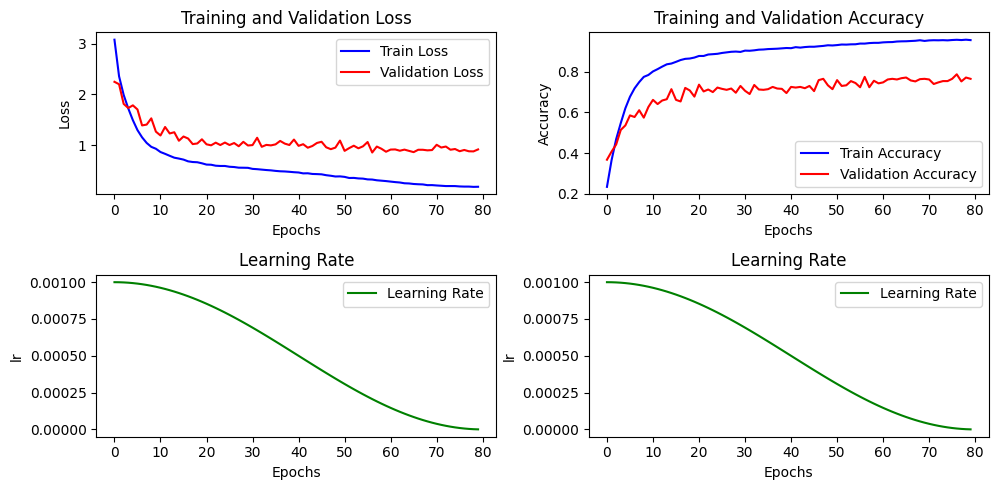

In [24]:
cut_epoch = epochs

# Plotting train and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.plot(range(cut_epoch), train_epoch_losses, 'b', label='Train Loss')
plt.plot(range(cut_epoch), val_epoch_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting train and validation accuracies
plt.subplot(2, 2, 2)
plt.plot(range(cut_epoch), train_epoch_accs, 'b', label='Train Accuracy')
plt.plot(range(cut_epoch), val_epoch_accs, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting larning rate history
plt.subplot(2, 2, 3)
plt.plot(range(cut_epoch), lr_history, 'g', label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.legend()

# Plotting larning rate history
plt.subplot(2, 2, 4)
plt.plot(range(cut_epoch), lr_history, 'g', label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.legend()

plt.tight_layout()
plt.show()

### Setup for Second Training

In [25]:
lr2 = 1e-4
optimizer2 = optim.SGD(net.parameters(), momentum=0.9, lr=lr2, weight_decay=0.05)
scheduler2 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer2, T_0=80, T_mult=2)
epochs2 = 80

### Start the Second Training

#### Train With Geometrically Augmented Images(with noise and blur randomly applied) + CutMix

In [26]:
for epoch in range(epochs, epochs + epochs2):
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    train_batch_loss = []
    train_batch_acc = []

    val_batch_loss = []
    val_batch_acc = []

    for i, (images, labels) in tqdm(enumerate(train_dl_1), desc=f"Train epoch {epoch}"):
        net.train()

        images, labels = cutmix(images, labels.squeeze())
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)
        loss = loss_function(preds, labels)

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        train_batch_loss.append(loss.item())

        net.eval()

    train_epoch_loss = torch.tensor(train_batch_loss).mean()
    train_epoch_losses.append(train_epoch_loss)
    train_epoch_accs.append(train_epoch_acc)

    net.eval()

    with torch.no_grad():
        for images, labels in val_dl:
            images = images.to(device)
            labels = labels.flatten().to(device)

            preds = net(images)

            loss = loss_function(preds, labels)
            val_batch_loss.append(loss.item())
            y_pred = (net.predict(images)).type(torch.FloatTensor).to(device)
            correct = (y_pred == labels).type(torch.FloatTensor)
            val_batch_acc.append(correct.mean())

    val_epoch_loss = torch.tensor(val_batch_loss).mean()
    val_epoch_acc = torch.tensor(val_batch_acc).mean()
    val_epoch_losses.append(val_epoch_loss)
    val_epoch_accs.append(val_epoch_acc)

    learningRate = optimizer2.param_groups[0]["lr"]

    print(f"Train Loss:      {train_epoch_loss:.4f}")
    print(f"Validation Loss: {val_epoch_loss:.4f} | Validation Accuracy: {val_epoch_acc * 100:.4f}%, lr = {learningRate:.8f}")

    lr_history.append(learningRate)
    scheduler2.step()

Train epoch 80: 530it [00:41, 12.90it/s]


Train Loss:      2.0157
Validation Loss: 1.0899 | Validation Accuracy: 72.3370%, lr = 0.00010000


Train epoch 81: 530it [00:41, 12.67it/s]


Train Loss:      1.9353
Validation Loss: 0.9642 | Validation Accuracy: 75.0397%, lr = 0.00009996


Train epoch 82: 530it [00:42, 12.55it/s]


Train Loss:      1.9448
Validation Loss: 1.0472 | Validation Accuracy: 75.8347%, lr = 0.00009985


Train epoch 83: 530it [00:44, 11.96it/s]


Train Loss:      1.9528
Validation Loss: 1.0730 | Validation Accuracy: 76.7886%, lr = 0.00009965


Train epoch 84: 530it [00:40, 13.16it/s]


Train Loss:      1.9306
Validation Loss: 0.9651 | Validation Accuracy: 78.0604%, lr = 0.00009938


Train epoch 85: 530it [00:41, 12.91it/s]


Train Loss:      1.9148
Validation Loss: 0.9703 | Validation Accuracy: 75.8347%, lr = 0.00009904


Train epoch 86: 530it [00:42, 12.44it/s]


Train Loss:      1.9450
Validation Loss: 0.9946 | Validation Accuracy: 78.2194%, lr = 0.00009862


Train epoch 87: 530it [00:42, 12.36it/s]


Train Loss:      1.9333
Validation Loss: 0.9816 | Validation Accuracy: 77.9014%, lr = 0.00009812


Train epoch 88: 530it [00:43, 12.28it/s]


Train Loss:      1.9824
Validation Loss: 1.0305 | Validation Accuracy: 75.8347%, lr = 0.00009755


Train epoch 89: 530it [00:43, 12.30it/s]


Train Loss:      1.9361
Validation Loss: 0.9950 | Validation Accuracy: 76.9475%, lr = 0.00009691


Train epoch 90: 530it [00:43, 12.20it/s]


Train Loss:      1.9571
Validation Loss: 1.0089 | Validation Accuracy: 75.3577%, lr = 0.00009619


Train epoch 91: 530it [00:40, 13.20it/s]


Train Loss:      1.9446
Validation Loss: 1.1277 | Validation Accuracy: 75.3577%, lr = 0.00009541


Train epoch 92: 530it [00:40, 12.94it/s]


Train Loss:      1.9276
Validation Loss: 0.9818 | Validation Accuracy: 78.5374%, lr = 0.00009455


Train epoch 93: 530it [00:42, 12.57it/s]


Train Loss:      1.9198
Validation Loss: 1.0073 | Validation Accuracy: 78.5374%, lr = 0.00009362


Train epoch 94: 530it [00:42, 12.54it/s]


Train Loss:      1.9694
Validation Loss: 1.1070 | Validation Accuracy: 74.0858%, lr = 0.00009263


Train epoch 95: 530it [00:41, 12.77it/s]


Train Loss:      1.9162
Validation Loss: 1.0342 | Validation Accuracy: 77.1065%, lr = 0.00009157


Train epoch 96: 530it [00:39, 13.27it/s]


Train Loss:      1.9819
Validation Loss: 0.9606 | Validation Accuracy: 76.7886%, lr = 0.00009045


Train epoch 97: 530it [00:44, 11.98it/s]


Train Loss:      1.9710
Validation Loss: 1.0245 | Validation Accuracy: 74.4038%, lr = 0.00008927


Train epoch 98: 530it [00:41, 12.65it/s]


Train Loss:      1.9273
Validation Loss: 1.0256 | Validation Accuracy: 77.4245%, lr = 0.00008802


Train epoch 99: 530it [00:41, 12.81it/s]


Train Loss:      1.9579
Validation Loss: 1.0309 | Validation Accuracy: 77.9014%, lr = 0.00008672


Train epoch 100: 530it [00:40, 13.14it/s]


Train Loss:      1.9444
Validation Loss: 1.1453 | Validation Accuracy: 73.1320%, lr = 0.00008536


Train epoch 101: 530it [00:41, 12.86it/s]


Train Loss:      1.9439
Validation Loss: 1.0042 | Validation Accuracy: 77.1065%, lr = 0.00008394


Train epoch 102: 530it [00:41, 12.73it/s]


Train Loss:      1.9744
Validation Loss: 1.0461 | Validation Accuracy: 76.9475%, lr = 0.00008247


Train epoch 103: 530it [00:41, 12.68it/s]


Train Loss:      1.9708
Validation Loss: 1.0946 | Validation Accuracy: 75.6757%, lr = 0.00008095


Train epoch 104: 530it [00:41, 12.80it/s]


Train Loss:      1.9500
Validation Loss: 1.0744 | Validation Accuracy: 76.9475%, lr = 0.00007939


Train epoch 105: 530it [00:39, 13.31it/s]


Train Loss:      1.9466
Validation Loss: 1.0830 | Validation Accuracy: 75.6757%, lr = 0.00007778


Train epoch 106: 530it [00:41, 12.82it/s]


Train Loss:      1.9656
Validation Loss: 1.0197 | Validation Accuracy: 76.7886%, lr = 0.00007612


Train epoch 107: 530it [00:41, 12.73it/s]


Train Loss:      1.9565
Validation Loss: 1.0878 | Validation Accuracy: 76.4706%, lr = 0.00007443


Train epoch 108: 530it [00:41, 12.75it/s]


Train Loss:      1.9498
Validation Loss: 1.0738 | Validation Accuracy: 76.3116%, lr = 0.00007270


Train epoch 109: 530it [00:40, 13.15it/s]


Train Loss:      1.9466
Validation Loss: 1.0655 | Validation Accuracy: 75.8347%, lr = 0.00007093


Train epoch 110: 530it [00:40, 13.22it/s]


Train Loss:      1.9566
Validation Loss: 1.0901 | Validation Accuracy: 77.5835%, lr = 0.00006913


Train epoch 111: 530it [00:42, 12.40it/s]


Train Loss:      1.9350
Validation Loss: 1.1057 | Validation Accuracy: 75.1987%, lr = 0.00006731


Train epoch 112: 530it [00:42, 12.40it/s]


Train Loss:      1.9549
Validation Loss: 1.0279 | Validation Accuracy: 77.9014%, lr = 0.00006545


Train epoch 113: 530it [00:42, 12.37it/s]


Train Loss:      1.9365
Validation Loss: 1.0932 | Validation Accuracy: 76.3116%, lr = 0.00006357


Train epoch 114: 530it [00:41, 12.66it/s]


Train Loss:      1.9381
Validation Loss: 1.0934 | Validation Accuracy: 76.1526%, lr = 0.00006167


Train epoch 115: 530it [00:40, 13.15it/s]


Train Loss:      1.9556
Validation Loss: 1.1065 | Validation Accuracy: 73.1320%, lr = 0.00005975


Train epoch 116: 530it [00:41, 12.67it/s]


Train Loss:      1.9968
Validation Loss: 1.1042 | Validation Accuracy: 76.4706%, lr = 0.00005782


Train epoch 117: 530it [00:42, 12.41it/s]


Train Loss:      1.9594
Validation Loss: 1.0507 | Validation Accuracy: 78.5374%, lr = 0.00005588


Train epoch 118: 530it [00:42, 12.53it/s]


Train Loss:      1.9350
Validation Loss: 1.1750 | Validation Accuracy: 72.6550%, lr = 0.00005392


Train epoch 119: 530it [00:42, 12.52it/s]


Train Loss:      1.9468
Validation Loss: 1.0406 | Validation Accuracy: 75.5167%, lr = 0.00005196


Train epoch 120: 530it [00:40, 12.98it/s]


Train Loss:      1.8916
Validation Loss: 1.1307 | Validation Accuracy: 75.6757%, lr = 0.00005000


Train epoch 121: 530it [00:40, 13.10it/s]


Train Loss:      1.8966
Validation Loss: 1.0799 | Validation Accuracy: 76.3116%, lr = 0.00004804


Train epoch 122: 530it [00:41, 12.63it/s]


Train Loss:      1.8935
Validation Loss: 1.1276 | Validation Accuracy: 73.9269%, lr = 0.00004608


Train epoch 123: 530it [00:42, 12.61it/s]


Train Loss:      1.9147
Validation Loss: 1.2059 | Validation Accuracy: 73.6089%, lr = 0.00004412


Train epoch 124: 530it [00:42, 12.62it/s]


Train Loss:      1.8932
Validation Loss: 1.1493 | Validation Accuracy: 75.6757%, lr = 0.00004218


Train epoch 125: 530it [00:41, 12.88it/s]


Train Loss:      1.9058
Validation Loss: 1.0531 | Validation Accuracy: 77.2655%, lr = 0.00004025


Train epoch 126: 530it [00:43, 12.12it/s]


Train Loss:      1.9545
Validation Loss: 1.1335 | Validation Accuracy: 74.2448%, lr = 0.00003833


Train epoch 127: 530it [00:40, 12.97it/s]


Train Loss:      1.8694
Validation Loss: 1.1163 | Validation Accuracy: 77.1065%, lr = 0.00003643


Train epoch 128: 530it [00:41, 12.70it/s]


Train Loss:      1.8630
Validation Loss: 1.2048 | Validation Accuracy: 74.5628%, lr = 0.00003455


Train epoch 129: 530it [00:41, 12.69it/s]


Train Loss:      1.8636
Validation Loss: 1.1347 | Validation Accuracy: 75.8347%, lr = 0.00003269


Train epoch 130: 530it [00:41, 12.69it/s]


Train Loss:      1.8710
Validation Loss: 1.1666 | Validation Accuracy: 75.5167%, lr = 0.00003087


Train epoch 131: 530it [00:39, 13.25it/s]


Train Loss:      1.8564
Validation Loss: 1.1467 | Validation Accuracy: 76.6296%, lr = 0.00002907


Train epoch 132: 530it [00:41, 12.84it/s]


Train Loss:      1.8594
Validation Loss: 1.0946 | Validation Accuracy: 75.0397%, lr = 0.00002730


Train epoch 133: 530it [00:41, 12.65it/s]


Train Loss:      1.8615
Validation Loss: 1.1807 | Validation Accuracy: 78.0604%, lr = 0.00002557


Train epoch 134: 530it [00:42, 12.58it/s]


Train Loss:      1.8450
Validation Loss: 1.0917 | Validation Accuracy: 78.0604%, lr = 0.00002388


Train epoch 135: 530it [00:41, 12.68it/s]


Train Loss:      1.8103
Validation Loss: 1.1277 | Validation Accuracy: 78.5374%, lr = 0.00002222


Train epoch 136: 530it [00:40, 13.13it/s]


Train Loss:      1.8326
Validation Loss: 1.0887 | Validation Accuracy: 77.7424%, lr = 0.00002061


Train epoch 137: 530it [00:40, 12.95it/s]


Train Loss:      1.8263
Validation Loss: 1.0609 | Validation Accuracy: 76.9475%, lr = 0.00001905


Train epoch 138: 530it [00:41, 12.63it/s]


Train Loss:      1.8230
Validation Loss: 1.2117 | Validation Accuracy: 75.5167%, lr = 0.00001753


Train epoch 139: 530it [00:43, 12.27it/s]


Train Loss:      1.8215
Validation Loss: 1.1640 | Validation Accuracy: 75.9936%, lr = 0.00001606


Train epoch 140: 530it [00:42, 12.56it/s]


Train Loss:      1.8432
Validation Loss: 1.1787 | Validation Accuracy: 75.8347%, lr = 0.00001464


Train epoch 141: 530it [00:40, 13.22it/s]


Train Loss:      1.8435
Validation Loss: 1.1163 | Validation Accuracy: 77.5835%, lr = 0.00001328


Train epoch 142: 530it [00:40, 13.03it/s]


Train Loss:      1.7810
Validation Loss: 1.1440 | Validation Accuracy: 75.8347%, lr = 0.00001198


Train epoch 143: 530it [00:42, 12.62it/s]


Train Loss:      1.7733
Validation Loss: 1.1942 | Validation Accuracy: 76.6296%, lr = 0.00001073


Train epoch 144: 530it [00:41, 12.70it/s]


Train Loss:      1.7932
Validation Loss: 1.1825 | Validation Accuracy: 77.5835%, lr = 0.00000955


Train epoch 145: 530it [00:41, 12.81it/s]


Train Loss:      1.8320
Validation Loss: 1.1125 | Validation Accuracy: 78.3784%, lr = 0.00000843


Train epoch 146: 530it [00:40, 13.24it/s]


Train Loss:      1.7592
Validation Loss: 1.1043 | Validation Accuracy: 78.5374%, lr = 0.00000737


Train epoch 147: 530it [00:41, 12.70it/s]


Train Loss:      1.7661
Validation Loss: 1.1286 | Validation Accuracy: 79.4913%, lr = 0.00000638


Train epoch 148: 530it [00:41, 12.64it/s]


Train Loss:      1.7809
Validation Loss: 1.1204 | Validation Accuracy: 78.0604%, lr = 0.00000545


Train epoch 149: 530it [00:41, 12.68it/s]


Train Loss:      1.7462
Validation Loss: 1.2480 | Validation Accuracy: 76.4706%, lr = 0.00000459


Train epoch 150: 530it [00:40, 13.09it/s]


Train Loss:      1.7734
Validation Loss: 1.2123 | Validation Accuracy: 77.1065%, lr = 0.00000381


Train epoch 151: 530it [00:40, 13.25it/s]


Train Loss:      1.7915
Validation Loss: 1.2265 | Validation Accuracy: 76.1526%, lr = 0.00000309


Train epoch 152: 530it [00:41, 12.84it/s]


Train Loss:      1.7834
Validation Loss: 1.1254 | Validation Accuracy: 78.3784%, lr = 0.00000245


Train epoch 153: 530it [00:42, 12.40it/s]


Train Loss:      1.7856
Validation Loss: 1.2819 | Validation Accuracy: 75.3577%, lr = 0.00000188


Train epoch 154: 530it [00:42, 12.59it/s]


Train Loss:      1.7425
Validation Loss: 1.1971 | Validation Accuracy: 78.2194%, lr = 0.00000138


Train epoch 155: 530it [00:39, 13.29it/s]


Train Loss:      1.7680
Validation Loss: 1.2780 | Validation Accuracy: 77.9014%, lr = 0.00000096


Train epoch 156: 530it [00:40, 13.02it/s]


Train Loss:      1.7428
Validation Loss: 1.2405 | Validation Accuracy: 77.1065%, lr = 0.00000062


Train epoch 157: 530it [00:41, 12.67it/s]


Train Loss:      1.7666
Validation Loss: 1.1849 | Validation Accuracy: 77.7424%, lr = 0.00000035


Train epoch 158: 530it [00:46, 11.45it/s]


Train Loss:      1.7361
Validation Loss: 1.2475 | Validation Accuracy: 76.1526%, lr = 0.00000015


Train epoch 159: 530it [00:41, 12.77it/s]


Train Loss:      1.7968
Validation Loss: 1.2031 | Validation Accuracy: 78.8553%, lr = 0.00000004


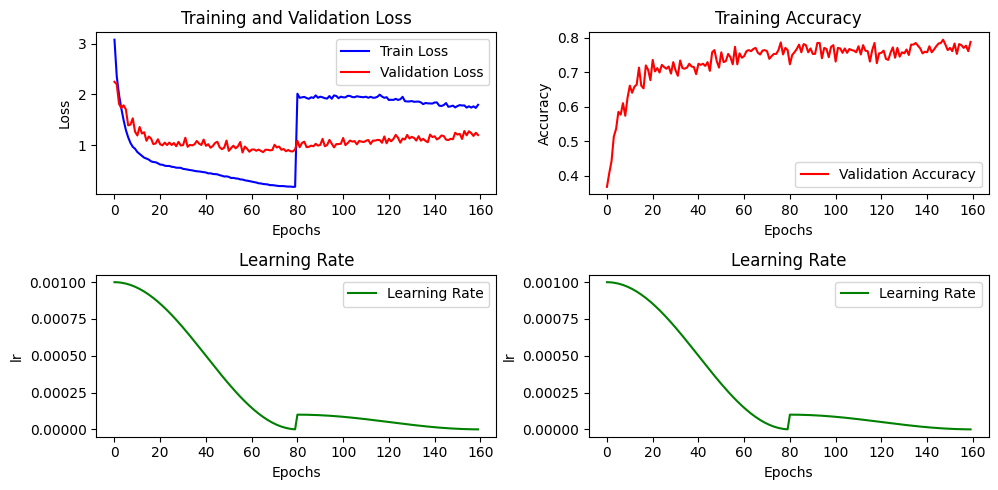

In [27]:
cut_epoch = epochs + epochs2

# Plotting train and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.plot(range(cut_epoch), train_epoch_losses, 'b', label='Train Loss')
plt.plot(range(cut_epoch), val_epoch_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting train and validation accuracies
plt.subplot(2, 2, 2)
plt.plot(range(cut_epoch), val_epoch_accs, 'r', label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting learning rate history
plt.subplot(2, 2, 3)
plt.plot(range(cut_epoch), lr_history, 'g', label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.legend()

# Plotting learning rate history
plt.subplot(2, 2, 4)
plt.plot(range(cut_epoch), lr_history, 'g', label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.legend()

plt.tight_layout()
plt.show()

#### Calculate Accuracies for Each Class

In [28]:
with torch.no_grad():
    for images, labels in val_dl:
        images = images.to(device)
        labels = labels.flatten().to(device)

        y_pred = (net.predict(images)).type(torch.FloatTensor).to(device)

class_acc, class_count = classwise_accuracy(y_pred.cpu(), labels.cpu())

print("Class-wise accuracies:")
for key, value in class_acc.items():
    print(f"Class {key}: {value}")

print("\nVal Class count:")
for key, value in class_count.items():
    print(f"Class {key}: {value}")

Class-wise accuracies:
Class 0: 0.64
Class 1: 0.9230769230769231
Class 2: 0.9
Class 3: 0.6470588235294118
Class 4: 0.4
Class 5: 0.7142857142857143
Class 6: 0.8108108108108109
Class 7: 0.9032258064516129
Class 8: 0.7741935483870968
Class 9: 0.6666666666666666
Class 10: 0.6875
Class 11: 0.5625
Class 12: 0.7777777777777778
Class 13: 0.896551724137931
Class 14: 1.0
Class 15: 0.6923076923076923
Class 16: 0.8
Class 17: 0.9523809523809523
Class 18: 0.8260869565217391
Class 19: 0.7391304347826086
Class 20: 0.7391304347826086
Class 21: 0.7777777777777778
Class 22: 0.7083333333333334
Class 23: 0.7666666666666667
Class 24: 0.75
Class 25: 0.9444444444444444
Class 26: 0.7142857142857143

Val Class count:
Class 0: 25
Class 1: 26
Class 2: 30
Class 3: 34
Class 4: 10
Class 5: 7
Class 6: 37
Class 7: 31
Class 8: 31
Class 9: 12
Class 10: 16
Class 11: 16
Class 12: 9
Class 13: 29
Class 14: 25
Class 15: 13
Class 16: 25
Class 17: 21
Class 18: 23
Class 19: 23
Class 20: 23
Class 21: 9
Class 22: 24
Class 23: 30


## Save Checkpoint

In [29]:
EPOCH = epochs + epochs2
PATH = "./Net_checkpoint.pt"
TRAIN_LOSS = train_epoch_losses
VAL_LOSS = val_epoch_losses
TRAIN_ACC = train_epoch_accs
VAL_ACC = val_epoch_accs
LR_HIS = lr_history

TRAIN_SET = train_set
VAL_SET = val_set

torch.save({
    'epoch' : EPOCH,
    'model_state_dict' : net.state_dict(),
    'train_loss' : TRAIN_LOSS,
    'val_loss' : VAL_LOSS,
    'train_acc' : TRAIN_ACC,
    'val_acc' : VAL_ACC,
    'lr_history' : LR_HIS,
    'train_set' : TRAIN_SET,
    'val_set' : VAL_SET
}, PATH)

## Check Last Validation Accuracy

In [30]:
total = len(val_set)
correct = 0

with torch.no_grad() :
  net.eval()
  for i in range(len(val_set)) :
    image = val_set[i][0].unsqueeze(0).to(device)
    label = val_set[i][1]

    preds = net(image)[0]
    pred_index = torch.argmax(preds).item()

    if pred_index == label:
      correct += 1

accuracy = correct / total
print(accuracy)

0.7885532591414944


## Output Result

In [33]:
submission = pd.read_csv('submission1.csv')

with torch.no_grad():
    for images in test_dl:
        images = images.to(device)

        y_pred = (net.predict(images))

submission['label'] = y_pred.cpu()
submission.to_csv('./submission_final.csv', index=False)

## Prediction Ensemble

In [ ]:
submission = pd.read_csv('food_datasets/submission.csv')
submission_best = pd.read_csv('submission_fin_1.csv')
submission_second_best = pd.read_csv('submission_final.csv')
submission_third_best = pd.read_csv('submission4 (1).csv')

for i in range(len(submission)):
    label1 = submission_best.loc[i, 'label']
    label2 = submission_second_best.loc[i, 'label']
    label3 = submission_third_best.loc[i, 'label']
    elected = max(set([label1, label2, label3]), key=[label1, label2, label3].count)
    submission.loc[i, 'label'] = elected.astype(int)

submission.to_csv('sub-fin.csv', index=False)